# Named Entity Linking with BERT

## Using BERT embeddings to aid in the task of End-to-End Named Entity Linking

### Task 1 - Read in the annotations and training dataset from AIDA-YAGO2 as well as the Wiki Entity Name/Id dataset

These tab-seperated files will be used to train our model

In [3]:
annotations_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\data\\AIDA-YAGO2-annotations.tsv'

In [4]:
import csv
import re

train_annotations = []
val_annotations = []
test_annotations = []

with open(annotations_file, encoding='utf-8') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    i = 0
    for row in reader:
        i += 1
        train_annotations.append(row)
        if row == ['-DOCSTART- (947testa CRICKET)']: # first validation document
            #print('validation data starts at index:', i-1)
            val_index = i-1
        if row == ['-DOCSTART- (1163testb SOCCER)']: # first test document
            #print('test data starts at index:', i-1)
            test_index = i-1
    
    val_annotations = train_annotations[val_index: test_index]
    test_annotations = train_annotations[test_index:]
    train_annotations = train_annotations[:val_index]
    
print('train mentions: ', len(train_annotations))
print('validation mentions: ', len(val_annotations))
print('test mentions: ', len(test_annotations))            

train mentions:  25288
validation mentions:  6349
test mentions:  6078


In [5]:
train_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\data\\basic_data\\test_datasets\\AIDA\\aida_train_unquoted.txt'

In [6]:
train_data_raw = []

with open(train_file, encoding='utf-8') as train_tsvfile:
    train_reader = csv.reader(train_tsvfile, delimiter='\t')
    for row in train_reader:
        train_data_raw.append(row)
    
train_data_raw[:490] # just show up to the second document

[['-DOCSTART- (1 EU)'],
 ['EU', 'B', 'EU', '--NME--'],
 ['rejects'],
 ['German',
  'B',
  'German',
  'Germany',
  'http://en.wikipedia.org/wiki/Germany',
  '11867',
  '/m/0345h'],
 ['call'],
 ['to'],
 ['boycott'],
 ['British',
  'B',
  'British',
  'United_Kingdom',
  'http://en.wikipedia.org/wiki/United_Kingdom',
  '31717',
  '/m/07ssc'],
 ['lamb'],
 ['.'],
 [],
 ['Peter', 'B', 'Peter Blackburn', '--NME--'],
 ['Blackburn', 'I', 'Peter Blackburn', '--NME--'],
 [],
 ['BRUSSELS',
  'B',
  'BRUSSELS',
  'Brussels',
  'http://en.wikipedia.org/wiki/Brussels',
  '3708',
  '/m/0177z'],
 ['1996-08-22'],
 [],
 ['The'],
 ['European',
  'B',
  'European Commission',
  'European_Commission',
  'http://en.wikipedia.org/wiki/European_Commission',
  '9974',
  '/m/02q9k'],
 ['Commission',
  'I',
  'European Commission',
  'European_Commission',
  'http://en.wikipedia.org/wiki/European_Commission',
  '9974',
  '/m/02q9k'],
 ['said'],
 ['on'],
 ['Thursday'],
 ['it'],
 ['disagreed'],
 ['with'],
 ['Germa

In [7]:
# create raw validation and test datasets
test_file = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\data\\basic_data\\test_datasets\\AIDA\\testa_testb_aggregate_unquoted.txt'

validation_data_raw = []
test_data_raw = []

with open(test_file, encoding='utf-8') as test_tsvfile:
    test_reader = csv.reader(test_tsvfile, delimiter='\t')
    for row in test_reader:
        validation_data_raw.append(row)

for i in range(len(validation_data_raw)):
    if validation_data_raw[i] == ['-DOCSTART- (1163testb SOCCER)']: # first test document
        test_index = i
        
test_data_raw = validation_data_raw[test_index:]
validation_data_raw = validation_data_raw[:test_index]

In [8]:
wikiName_id_mapFile = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\data\\basic_data\\wiki_name_id_map.txt'

In [9]:
with open(wikiName_id_mapFile, encoding='utf-8') as wikiMap_tsvfile:
    wikiMap_reader = csv.reader(wikiMap_tsvfile, delimiter='\t')
    wikiName_id_map_dict = {int(row[1]): row[0] for row in wikiMap_reader if row[0][0].isalpha() or row[0][0].isnumeric()}

wikiName_id_map_dict[31717]

'United Kingdom'

### Task 2 - Pre-process the training data

In [30]:
# Import modules that will be used downstream

import json
import pickle
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
import time
import io
import matplotlib.pyplot as plt
from random import shuffle

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

#from sklearn.model_selection import train_test_split

from datetime import datetime

In [11]:
local_bert_path = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_project\\bert'
# local path where the bert module has been cloned from git

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)

In [12]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

In [18]:
# Use the bert model that is cased
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

Create a BERT tokenizer so that words can be tokenized for BERT input

In [19]:
sess = tf.Session()
graph = tf.get_default_graph()

bert_module = hub.Module(bert_url)
tokenization_info = bert_module(signature="tokenization_info", as_dict=True)

vocab_file, do_lower_case = tf.Session().run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])

tokenizer = tokenization.FullTokenizer(
    vocab_file = vocab_file, do_lower_case = do_lower_case
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
# Make sure the tokenizer works
tokenizer_test = tokenizer.tokenize('This tokenizer, is it even working?')
tokenizer_test

['This', 'token', '##izer', ',', 'is', 'it', 'even', 'working', '?']

In [21]:
tokenizer_ids_test = tokenizer.convert_tokens_to_ids(tokenizer_test)
tokenizer_ids_test

[1188, 22559, 17260, 117, 1110, 1122, 1256, 1684, 136]

In [22]:
tokenizer.convert_ids_to_tokens(tokenizer_ids_test)
# seems legit

['This', 'token', '##izer', ',', 'is', 'it', 'even', 'working', '?']

Now the BERT tokenizer can be used to create tokens from the input text that can be used by the BERT model (more on that later).

To simplify things, create a function that creates dictionary objects for document text, NER tags, entity Ids, and wikipedia URLs given row-by-row data (from training or test set)

In [23]:
len(train_data_raw)

218505

In [24]:
def createUtilityDicts(data_rows):

    data_text_dict = {}
    data_nerTag_dict = {}
    data_entityId_dict = {}
    data_wikiUrl_dict = {}

    # set the first DOCSTART of the train data as the dict key
    dict_key = data_rows[0][0]
    # create empty lists for dict values
    text_dict_values = []
    nerTag_dict_values = []
    entityId_dict_values = []
    wikiUrl_dict_values = []

    for row in data_rows[1:]:

        if row == []: #signaling end of sentence
            text_dict_values.append('[SEP]')
            nerTag_dict_values.append('[nerSEP]')
            entityId_dict_values.append('[entSEP]')
            wikiUrl_dict_values.append('[urlSEP]')

        elif len(row[0]) > 9 and row[0][:10] == '-DOCSTART-': # signaling a new document
            data_text_dict.update({dict_key : text_dict_values})
            data_nerTag_dict.update({dict_key : nerTag_dict_values})
            data_entityId_dict.update({dict_key : entityId_dict_values})
            data_wikiUrl_dict.update({dict_key : wikiUrl_dict_values})

            # reset key and value objects
            dict_key = row[0]
            text_dict_values = []
            nerTag_dict_values = []
            entityId_dict_values = []
            wikiUrl_dict_values = []

        elif len(row) > 1: # i.e. there is an entity mention
            for i in range(len(row)): # skip the possibly variable number of wiki names
                if row[i][:4] == 'http' or row[i] == '--NME--':
                    wikiUrl = row[i]                
                    if row[i][:4] == 'http': # only for cases where there is a wiki url
                        entityId = row[i-1] # append the wiki entity name, which precedes the url
                    else:
                        entityId = '--NME--'
            
            for i in range(len(tokenizer.tokenize(row[0]))): 
                text_dict_values.append(tokenizer.tokenize(row[0])[i]) # append all tokenized strings
                nerTag_dict_values.append(row[1]) # append same NER tag for each token
                wikiUrl_dict_values.append(wikiUrl) # append same Wiki URL for each token
                entityId_dict_values.append(entityId) # append same enitity Id for each token

        else: # i.e. there is no entity mention
            for i in range(len(tokenizer.tokenize(row[0]))): # append all tokenized strings
                text_dict_values.append(tokenizer.tokenize(row[0])[i])
                if i == 0:
                    nerTag_dict_values.append('O')
                else:
                    nerTag_dict_values.append('nerX')
                entityId_dict_values.append(None)
                wikiUrl_dict_values.append(None)

    return data_text_dict, data_nerTag_dict, data_entityId_dict, data_wikiUrl_dict

In [25]:
train_text_dict, train_nerTag_dict, train_entityId_dict, train_wikiUrl_dict = createUtilityDicts(train_data_raw)

val_text_dict, val_nerTag_dict, val_entityId_dict, val_wikiUrl_dict = createUtilityDicts(validation_data_raw)

test_text_dict, test_nerTag_dict, test_entityId_dict, test_wikiUrl_dict = createUtilityDicts(test_data_raw)

Check some descriptive statistics on the sentence lengths

In [26]:
sentenceLengths = []

for sentences in train_text_dict.values():
    i = 0
    for token in sentences:
        if token != '[SEP]':
            i += 1
        else:
            sentenceLengths.append(i)
            i = 0

In [27]:
print('sentence mean', np.mean(sentenceLengths))
print('max sentence length', max(sentenceLengths))

sentence mean 16.784703253041968
max sentence length 171


(array([1.389e+03, 9.000e+02, 9.300e+02, 1.160e+03, 1.899e+03, 1.486e+03,
        1.186e+03, 8.170e+02, 7.220e+02, 5.450e+02, 5.910e+02, 5.220e+02,
        5.010e+02, 4.660e+02, 4.350e+02, 3.930e+02, 3.750e+02, 3.210e+02,
        2.780e+02, 2.520e+02, 1.620e+02, 1.610e+02, 1.460e+02, 1.040e+02,
        1.060e+02, 6.400e+01, 5.500e+01, 4.500e+01, 2.200e+01, 1.500e+01,
        1.600e+01, 1.100e+01, 6.000e+00, 3.000e+00, 7.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

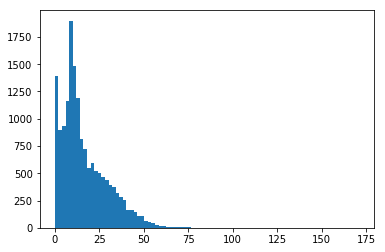

In [33]:
plt.hist(sentenceLengths, bins=85) #bins=170)

## Task 3 - Generate input for the BERT model

Because BERT has a limit of 512 tokens per input, I will try to split documents up into the component sentences, using the max sentence length of 50-75 for training. As can be seen by the histogram above, almost all sentences will fall into this range.

Additionally, for each sentence we will need to add [CLS] and [PAD] tokens

Will need **Sentences, NER Tokens,** and **entity ids**

In [34]:
def createBertTextObjects(text_dict, nerTag_dict, entId_dict, max_sentence_length):
    """
    Add [CLS] and [PAD] tokens to text, NER tag, and entity Id data 
    [PAD] tokens are added until max_sentence_length
    returns bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids
    *Concepts borrowed from BERT_NER_v1
    """
    max_sentence_length -= 1 # to account for Python's zero-based indexing
    
    bert_sentences = []
    bert_ner_tags = []
    bert_entities = []
    bert_mask_ids = []
    
    # start with [CLS] token
    sentence = ['[CLS]'] 
    ner_tags = ['[nerCLS]']
    entity_ids = ['[entCLS]']
    
    for item in text_dict:
    
        for i in range(len(text_dict[item])):

            if text_dict[item][i] == '[SEP]':
                sentence_length = min(max_sentence_length, len(sentence))

                # truncate sequences that are longer than the max_sentence_length
                sentence = sentence[:max_sentence_length-1]
                ner_tags = ner_tags[:max_sentence_length-1]
                entity_ids = entity_ids[:max_sentence_length-1]

                # mask all [PAD] items
                bert_mask_ids.append([1] * (sentence_length + 1) + 
                                     [0] * (max_sentence_length - sentence_length))

                # insert final [SEP] and [PAD] tokens
                sentence += [text_dict[item][i]] + ['[PAD]'] * (max_sentence_length - len(sentence))
                ner_tags += [nerTag_dict[item][i]] + ['[nerPAD]'] * (max_sentence_length - len(ner_tags))
                entity_ids += [entId_dict[item][i]] + ['[entPAD]'] * (max_sentence_length - len(entity_ids))

                bert_sentences.append(sentence)
                bert_ner_tags.append(ner_tags)
                bert_entities.append(entity_ids)

                # restart with [CLS] token
                sentence = ['[CLS]'] 
                ner_tags = ['[nerCLS]']
                entity_ids = ['[entCLS]']
            else:    
                sentence += [text_dict[item][i]]
                ner_tags += [nerTag_dict[item][i]]
                entity_ids += [entId_dict[item][i]]
            
    bert_mask_ids = np.asarray(bert_mask_ids)
            
    return bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids
        

In [35]:
max_sentence_length = 50

bert_sentences, bert_ner_tags, bert_entities, bert_mask_ids = createBertTextObjects(train_text_dict,
                                                                       train_nerTag_dict,
                                                                       train_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

val_sentences, val_ner_tags, val_entities, val_mask_ids = createBertTextObjects(val_text_dict,
                                                                       val_nerTag_dict,
                                                                       val_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

test_sentences, test_ner_tags, test_entities, test_mask_ids = createBertTextObjects(test_text_dict,
                                                                       test_nerTag_dict,
                                                                       test_entityId_dict,
                                                                       max_sentence_length = max_sentence_length)

Now we have our BERT inputs as text, we need to modify all inputs to be numerical values

Approach 1 - NER tags as categorical codes

In [36]:
def createBertNumObjects1(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to categorical codes
    nerTag_categories = pd.DataFrame(np.array(bert_ner_tags).reshape(-1))
    nerTag_categories.columns = ['text']
    nerTag_categories.text = pd.Categorical(nerTag_categories.text)
    nerTag_categories['cat'] = nerTag_categories.text.cat.codes
    nerTag_categories['sym'] = nerTag_categories.cat 
    
    nerDistribution = (nerTag_categories.groupby(['text','cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))
    #print(nerDistribution)
    
    bert_nerTag_ids = np.array(nerTag_categories.cat, dtype=np.int32).reshape(len(bert_ner_tags), len(bert_ner_tags[0]))
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

Approach 2 - Binary tags (i.e. is entity or is not entity)

In [37]:
def createBertNumObjects2(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to binary 'is-entity' boolean
    bert_nerTag_ids = []
    for item in bert_ner_tags:
        sentenceTags = []
        for tag in item:
            if tag in ['B','I']: # i.e. tag corresponds with an entity
                sentenceTags.append([1])
            else:
                sentenceTags.append([0])
        bert_nerTag_ids.append(sentenceTags)
    
    bert_nerTag_ids = np.asarray(bert_nerTag_ids)
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

Approach 3 - codes for only relevant tags

In [38]:
def createBertNumObjects3(bert_sentences, bert_ner_tags):
    """
    Converts BERT text objects created from the createBertTextObjects output into numerical arrays
    """
    
    bert_sentence_ids = []
    
    # convert sentence text to token ids using tokenizer
    for sentence in bert_sentences:
        bert_sentence_ids.append(tokenizer.convert_tokens_to_ids(sentence))
        
    bert_sentence_ids = np.asarray(bert_sentence_ids, dtype=np.int32)
        
    # convert NER tag text to binary 'is-entity' boolean
    bert_nerTag_ids = []
    for item in bert_ner_tags:
        sentenceTags = []
        for tag in item:
            if tag == 'B': # i.e. tag corresponds with an entity
                sentenceTags.append([1])
            elif tag == 'I':
                sentenceTags.append([2])
            else:
                sentenceTags.append([0])
        bert_nerTag_ids.append(sentenceTags)
    
    bert_nerTag_ids = np.asarray(bert_nerTag_ids)
    
    # create a sequence id array (which will just be all zero values)
    bert_seq_ids = []

    for i in range(len(bert_sentence_ids)):
        seq_list = ([0] * len(bert_sentence_ids[i]))
        bert_seq_ids.append(seq_list)

    bert_seq_ids = np.asarray(bert_seq_ids)
    
    return bert_sentence_ids, bert_nerTag_ids, bert_seq_ids
        

In [39]:
bert_sentence_ids, bert_nerTag_ids, bert_seq_ids = createBertNumObjects3(bert_sentences, bert_ner_tags)

val_sentence_ids, val_nerTag_ids, val_seq_ids = createBertNumObjects3(val_sentences, val_ner_tags)

test_sentence_ids, test_nerTag_ids, test_seq_ids = createBertNumObjects3(test_sentences, test_ner_tags)

In [40]:
print(bert_sentence_ids.shape)
print(bert_nerTag_ids.shape) # extra dim of 1 for labels
print(bert_seq_ids.shape)

(16108, 50)
(16108, 50, 1)
(16108, 50)


### Build the BERT model with custom accuracy function!

In [41]:
#tf.reset_default_graph()

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    
def clear_and_set_sess(sess):
    K.clear_session()
    K.set_session(sess)

#sess = tf.Session()
#graph = tf.get_default_graph()

First we will use a custom accuracy function to show how accurate the model performs with regards to 'B' and 'I' tags only

In [42]:
def is_entity_accuracy(y_true, y_pred):
    """
    Calculate accuracy of predicting 'B' and 'I' lables only
    
    y_true: actual NER tag codes with the 'O' value (0) masked
    y_pred: predicted NER tag codes with the 'O' value (0) masked 
    
    returns accuracy measure
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int32)),[-1])
    mask = (y_label > 0) # evaluates to True for all non 'O'/0 labels
    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),[-1,3])
    y_max_pred = tf.cast(tf.math.argmax(input = y_flat_pred, axis=1), tf.int32) # take the max predicted value
    y_pred_masked = tf.boolean_mask(y_max_pred, mask) # mask the predictions as well
    
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_masked, y_label_masked), dtype=tf.float64))


Let's make sure this works the way we want

In [43]:
y_true = tf.constant([1,0,1,0])
y_pred = tf.constant([[0.9,0.05,0.05],[0.9,0.05,0.05],[0.05,0.9,0.05],[0.05,0.9,0.05]])

print(is_entity_accuracy(y_true, y_pred).eval(session=sess))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.5


Now that it is working, we can create the BERT layer

Code borrowed from: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [44]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="sequence",
        bert_url = bert_url,
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

Summary metrics for the Tensor board

In [45]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

And a custom adam optimizer that can be adjusted

In [46]:
custom_adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.915, beta_2=0.999, epsilon=None, decay=0.05, amsgrad=False)

# Notes for modeling

### 1. Sentence input -> BERT -> NER hidden layers -> predict NER tags / is-entity, is-not-entity
### 2. Create BERT entity embeddings -> Take first N tokens from wiki summary, aggregate (average) the word embeddings to get a single vector
### 3. Use some similarity function to generate N possible Entity Candidates -> Dense layer(N, softmax)

In [47]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
# Build model --> sentence inputs -> Bert layer -> Dense layer -> softmax is-entity prediction

in_id = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_token_ids")
in_mask = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_input_masks")
in_segment = tf.keras.layers.Input(shape=(max_sentence_length,), name="bert_seq_ids")

bert_inputs = [in_id, in_mask, in_segment]

# Instantiate the custom Bert Layer defined above
bert_output = BertLayer(n_fine_tune_layers=4)(bert_inputs)

# Build the rest of the classifier 
dense = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(bert_output)
dense = tf.keras.layers.Dropout(rate=0.3, name='dropout_1')(dense)
dense = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(dense)
dense = tf.keras.layers.Dropout(rate=0.1, name='dropout_2')(dense)

# prediction layer
ner_pred = tf.keras.layers.Dense(3, activation='softmax', name='entity_identification')(dense)
# take the maximum predicted value
#pred = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(pred, tf.float64)),[-1, 3]), axis=1)


initialize_vars(sess)

ner_model = tf.keras.models.Model(inputs=bert_inputs, outputs=ner_pred)
#ner_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',
#                                                                                is_entity_accuracy])
ner_model.compile(loss='sparse_categorical_crossentropy', optimizer=custom_adam, metrics=['accuracy',
                                                                                is_entity_accuracy])
ner_model.summary()


with graph.as_default():
    K.set_session(sess)
    
    ner_model.fit(
        [bert_sentence_ids, bert_mask_ids, bert_seq_ids], 
        bert_nerTag_ids,
        validation_data=([val_sentence_ids, val_mask_ids, val_seq_ids], 
                         val_nerTag_ids),
        epochs=8,
        batch_size=16
    )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_token_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_seq_ids (InputLayer)       [(None, 50)]         0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, None, 768)    108931396   bert_token_ids[0][0]             
                                                                 bert_input_masks[0][0]       

In [ ]:
def shuffle_data_and_lables(sentence_ids, mask_ids, seq_ids, nerTag_ids):
    if sentence_ids.shape[0] == mask_ids.shape[0] == seq_ids.shape[0] == nerTag_ids.shape[0]:
        shuffle_index = np.random.permutation(sentence_ids.shape[0])
        
        sentence_ids_shuf = sentence_ids[shuffle_index]
        mask_ids_shuf = mask_ids[shuffle_index]
        seq_ids_shuf = seq_ids[shuffle_index]
        nerTag_ids_shuf = nerTag_ids[shuffle_index]
        
        return sentence_ids_shuf, mask_ids_shuf, seq_ids_shuf, nerTag_ids_shuf
        
    else:
        print('Incompatible shapes')

In [ ]:
#sess.close()

In [38]:
bert_test = [val_sentence_ids, val_mask_ids, val_seq_ids]

result = ner_model.predict(
    bert_test, 
    batch_size=16
)

In [43]:
is_entity_preds = []

# for each sentence in result
for i in range(len(result)):
    # for each token in the sentence
    sentence_preds = []
    for j in range(len(result[i])):
        # append the index of the max predicted value
        index_value = np.where(result[i][j] == np.amax(result[i][j]))[0][0]
        sentence_preds.append(index_value)
    is_entity_preds.append(sentence_preds) 
    
is_entity_preds = np.asarray(is_entity_preds)

In [50]:
view_result = list(zip(val_sentences[2],is_entity_preds[2],val_nerTag_ids[2]))
view_result

[('[CLS]', 0, array([0])),
 ('West', 1, array([1])),
 ('Indian', 2, array([2])),
 ('all', 0, array([0])),
 ('-', 0, array([0])),
 ('round', 0, array([0])),
 ('##er', 0, array([0])),
 ('Phil', 1, array([1])),
 ('Simmons', 2, array([2])),
 ('took', 0, array([0])),
 ('four', 0, array([0])),
 ('for', 0, array([0])),
 ('38', 0, array([0])),
 ('on', 0, array([0])),
 ('Friday', 0, array([0])),
 ('as', 0, array([0])),
 ('Leicestershire', 1, array([1])),
 ('beat', 0, array([0])),
 ('Somerset', 1, array([1])),
 ('by', 0, array([0])),
 ('an', 0, array([0])),
 ('innings', 0, array([0])),
 ('and', 0, array([0])),
 ('39', 0, array([0])),
 ('runs', 0, array([0])),
 ('in', 0, array([0])),
 ('two', 0, array([0])),
 ('days', 0, array([0])),
 ('to', 0, array([0])),
 ('take', 0, array([0])),
 ('over', 0, array([0])),
 ('at', 0, array([0])),
 ('the', 0, array([0])),
 ('head', 0, array([0])),
 ('of', 0, array([0])),
 ('the', 0, array([0])),
 ('county', 0, array([0])),
 ('championship', 0, array([0])),
 ('.'

## Task 4 - Create entity embeddings for Wikipedia entities

### This will help the task of Candidate Generation for the model

Using the wikiName_id_map_dict created earlier, scrape wikipedia articles for text descriptions of the entity

In [48]:
import wikipedia

In [49]:
print(wikipedia.WikipediaPage(title = 'Brussels').summary[:512])

Brussels (French: Bruxelles [bʁysɛl] (listen) or [bʁyksɛl]; Dutch: Brussel [ˈbrʏsəl] (listen)), officially the Brussels-Capital Region (French: Région de Bruxelles-Capitale; Dutch: Brussels Hoofdstedelijk Gewest), is a region of Belgium comprising 19 municipalities, including the City of Brussels, which is the capital of Belgium. The Brussels-Capital Region is located in the central portion of the country and is a part of both the French Community of Belgium and the Flemish Community, but is separate from t


In [50]:
entity_summary_ids_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\entity_summary_ids.npy'
entity_mask_ids_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\entity_mask_ids.npy'
entity_seq_ids_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\data\\entity_seq_ids.npy'
output_entities_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\output_entities.data'
entities_ext_filepath = 'C:\\Users\\andre\\Documents\\Berkeley\\w266\\w266_Project\\w266_Project\\entity_ext.data'

### For loading pre-created entity objects

Below cell can be run to open files

In [52]:
entity_summary_ids = np.load(entity_summary_ids_filepath)
entity_mask_ids = np.load(entity_mask_ids_filepath)
entity_seq_ids = np.load(entity_seq_ids_filepath)

with open(output_entities_filepath, 'rb') as file_in:
    output_entities = pickle.load(file_in)

with open(entities_ext_filepath, 'rb') as file_in:
    entities_ext = pickle.load(file_in)    

In [55]:
entity_summary_ids.shape

(55890, 300)

### Once run, skip to "Encode the entities as vectors"

### For loading entity and summaries the first time

In [ ]:
start_time = time.time()

wikiId_summaryTokens_dict = {}
i = 0
for wikiId in wikiName_id_map_dict:

    if i > 100:
        break # control
    i += 1
    try:
        summary = wikipedia.summary(wikiName_id_map_dict[wikiId])
    except:
        summary = None
        
    if summary:
        dict_value = tokenizer.tokenize(summary)[:512] # max_length
        dict_value = tokenizer.convert_tokens_to_ids(dict_value)
        wikiId_summaryTokens_dict.update({wikiId: dict_value})

timing = time.time() - start_time
print('100 Wikipedia page summaries executed in',round(timing,2),'seconds')

Given that the summary extraction takes so long, I'm going to cheat a bit to encode the entities as BERT 768 dimensional pooled vectors

In [51]:
entities = []

for item in train_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
for item in validation_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities    
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
for item in test_data_raw:
    if len(item) > 1 and item[1][:7] != '--NME--': # skip -DOCSTART-, --NME--, and non-entities
        for i in range(len(item)):
            if item[i][:4] == 'http': # index of the url
                stop_index = i
                entities.extend(item[2:stop_index])
        
entities = list(set(entities)) # unique entities only

# replace unicode characters
for i in range(len(entities)):
    if '\\u' in entities[i]:
        entities[i] = entities[i].encode().decode('unicode_escape')

In [ ]:
entities[:20]

Now let's add some noise to our entities

In [ ]:
entities_ext = []
start_time = time.time()
i = 1

for entity in entities:
    ent_start_time = time.time()
    print(entity, ' - ', str(round((i/len(entities)*100),3))+'%')
    entities_ext.extend(wikipedia.search(entity,results=5))
    timing = time.time() - ent_start_time
    print('\t', round(timing,2),'seconds')
    i += 1

timing = time.time() - start_time

print('\n\n')
print('Created noise for',len(entities),'entities. Executed in', round((timing/60),2),'minutes \n\n')

In [53]:
def createBertEntityObjects(entity_list, num_entities = 10, max_length=512):
    """
    Given an list of entities, output numerical bert token ids, mask ids, and sequence ids
    Last output is the text list of each entity that is contained in the vectors
    Used for input into the bert entity vectors
    Starts at 10 entities for output
    """
    
    start_time = time.time()
    
    max_length -= 2 # account for CLS and SEP tokens
    
    entity_summary_ids = []
    entity_mask_ids = []
    entity_seq_ids = []
    output_entities = []
    
    i = 1

    for item in entity_list[:num_entities]:
        # give run time information as this step can take a long time
        item_start_time = time.time()
        print(item, ' - ', str(round((i/num_entities*100),3))+'%')
        try:
            summary = tokenizer.tokenize(wikipedia.summary(item))[:max_length] 
        except:
            summary = None

        if summary:
            num_pads = max_length - len(summary) 
            masks = ([1] * (len(summary)+2)) + ([0] * num_pads) # no need to account for CLS and SEP pads
            summary = ['[CLS]'] + summary + ['[SEP]'] + (['[PAD]'] * num_pads)
            summary = tokenizer.convert_tokens_to_ids(summary)

            output_entities.append(item)
            entity_summary_ids.append(np.asarray(summary))
            entity_mask_ids.append(np.asarray(masks))
            entity_seq_ids.append(np.asarray([1] * (max_length + 2))) # no need to account for CLS and SEP pads
        
        timing = time.time() - item_start_time
        print('\t', round(timing,2),'seconds')
        i += 1

    entity_summary_ids = np.asarray(entity_summary_ids)
    entity_mask_ids = np.asarray(entity_mask_ids)
    entity_seq_ids = np.asarray(entity_seq_ids)

    timing = time.time() - start_time
    print('\n\n')
    
    print(len(entity_summary_ids), 'Wikipedia page summaries executed in',round((timing/60),2),'minutes')
    print('entity_summary_ids shape:', entity_summary_ids.shape)
    print('entity_mask_ids shape:', entity_mask_ids.shape)
    print('entity_seq_ids shape:', entity_seq_ids.shape)
    print('Number of text entities:',len(output_entities))
    
    return entity_summary_ids, entity_mask_ids, entity_seq_ids, output_entities

In [54]:
len(entities_ext)

58846

**Running this with all extended entities takes ~22 hours**

In [376]:
entities_ext[1040:1042]

['The Championship (TV programme)', 'Duma']

In [493]:
tokenizer.tokenize(wikipedia.summary('The Championship (TV programme)'))[:2]

['The', 'Championship']

In [378]:
wikipedia.summary('Duma')

'A duma (дума) was a Russian assembly with advisory or legislative functions. The term comes from the Russian verb думать (dumat’) meaning "to think" or "to consider". The first formally constituted duma was the State Duma introduced into the Russian Empire by Tsar Nicholas II in 1905 after the revolt of people against him demanding for the elected assembly. The Tsar dismissed the first duma within 75 days and re-elected second duma within three months. It was dissolved in 1917 during the Russian Revolution. Since 1993, the State Duma is the lower legislative house of the Russian Federation.'

In [521]:
num_entities = 2 #len(entities_ext)
max_length = 50

entity_summary_ids, entity_mask_ids, entity_seq_ids, output_entities = createBertEntityObjects(entities_ext[1040:1042], 
                                                                              num_entities = num_entities,
                                                                              max_length = max_length)

The Championship (TV programme)  -  50.0%
	 0.01 seconds
Duma  -  100.0%
	 0.01 seconds



2 Wikipedia page summaries executed in 0.0 minutes
entity_summary_ids shape: (2, 50)
entity_mask_ids shape: (2, 50)
entity_seq_ids shape: (2, 50)
Number of text entities: 2


In [413]:
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

In [416]:
test_summary = []

for token in tokenizer.convert_ids_to_tokens(entity_summary_ids[1]):
    if token not in stopwords:
        test_summary.append(token)

In [501]:
tokenizer.convert_ids_to_tokens(entity_summary_ids[1])

['[CLS]', 'A', 'du', '##ma', '[SEP]']

In [86]:
num_entities = 50 #len(entities_ext)
max_length = 300

entity_summary_ids, entity_mask_ids, entity_seq_ids, output_entities = createBertEntityObjects(entities_ext[1000:1050], 
                                                                              num_entities = num_entities,
                                                                              max_length = max_length)

1993 World Championships in Athletics – Women's 10,000 metres  -  2.0%
	 2.13 seconds
Luis García (footballer, born 1978)  -  4.0%
	 1.66 seconds
Luis García  -  6.0%
	 1.79 seconds
Luis García Postigo  -  8.0%
	 1.57 seconds
Luis García (footballer, born 1972)  -  10.0%
	 1.77 seconds
Luis García Meza  -  12.0%
	 1.61 seconds
Vicente Solano Lima  -  14.0%
	 1.77 seconds
March 1973 Argentine general election  -  16.0%
	 1.77 seconds
Isabel Martínez de Perón  -  18.0%
	 1.72 seconds
Héctor José Cámpora  -  20.0%
	 1.69 seconds
Raúl Alberto Lastiri  -  22.0%
	 1.65 seconds
Sale Sharks  -  24.0%
	 1.66 seconds
Faf de Klerk  -  26.0%
	 1.64 seconds
Jean-Luc du Preez  -  28.0%
	 1.77 seconds
Tom Curry (rugby union)  -  30.0%
	 1.63 seconds
Lood de Jager  -  32.0%
	 1.72 seconds
Maccabi Petah Tikva F.C.  -  34.0%
	 1.7 seconds
Petah Tikva  -  36.0%
	 1.95 seconds
Dia Saba  -  38.0%
	 1.64 seconds
Guy Luzon  -  40.0%
	 1.6 seconds
Maccabi Petah Tikva (handball)  -  42.0%
	 1.93 seconds
Missis

In [87]:
x = ['Sue','Graf','##ton']
text_x = ' '.join(x).replace(' ##','')
text_x 

'Sue Grafton'

### Encode the entities as vectors

In [502]:
#bert_module = hub.Module("https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1", trainable=True)

bert_entity_inputs = dict(
    input_ids=entity_summary_ids,
    input_mask=entity_mask_ids,
    segment_ids=entity_seq_ids)

# use pooled_output so that each entity has a 768-dimensional vector
bert_entity_outputs = bert_module(bert_entity_inputs, signature="tokens", as_dict=True)["pooled_output"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [503]:
bert_entity_outputs.shape

TensorShape([Dimension(2), Dimension(768)])

In [504]:
#initialize_vars(sess)

bert_entity_arr = bert_entity_outputs.eval(session=sess)

In [505]:
type(bert_entity_arr)

numpy.ndarray

In [506]:
bert_entity_outputs.shape

TensorShape([Dimension(2), Dimension(768)])

### Encode sentences as vectors

Example sentences

In [507]:
# pull the BERT sentence ids associated with our test entities

entity_annotations = []
entity_sentences = []

entity_sentence_ids = []
entity_masks = []
entity_seq_ids = []
entity_nerTag_ids = []

# iterate through entity sentences
for i in range(len(bert_entities)):
    sentence_with_entity = None
    # iterate through sentence tokens
    for j in range(len(bert_entities[i])):
    # if a sentence has an entity in our example list,
    # append bert token, mask, and sequence ids
        #if bert_entities[i][j] in entities_ext[1000:1050]:
        if bert_entities[i][j] in entities_ext[1040:1042]:
            sentence_with_entity = bert_entities[i]
    if sentence_with_entity:
        # raw data to help with evaluation
        entity_annotations.append(bert_entities[i])
        entity_sentences.append(bert_sentences[i])
        # bert numerical inputs
        entity_sentence_ids.append(bert_sentence_ids[i])
        entity_masks.append(bert_mask_ids[i])
        entity_seq_ids.append(bert_seq_ids[i])
        entity_nerTag_ids.append(bert_nerTag_ids[i])
        
entity_sentence_ids = np.asarray(entity_sentence_ids)
entity_masks = np.asarray(entity_masks)
entity_seq_ids = np.asarray(entity_seq_ids)
entity_nerTag_ids = np.asarray(entity_nerTag_ids)

In [508]:
print('entity vector shapes:',bert_entity_outputs.shape)
print('\t',bert_entity_outputs.shape[0], 'summaries, each represented as a',
      bert_entity_outputs.shape[1],'dimensional vector')

#print('sentence vector shapes:',bert_sentence_outputs.shape)
#print('\t',bert_sentence_outputs.shape[0], 'sentences, each having',
#      bert_sentence_outputs.shape[1],'tokens, each of which is represented as a',
#     bert_sentence_outputs.shape[2],'dimensional vector')

entity vector shapes: (2, 768)
	 2 summaries, each represented as a 768 dimensional vector


In the sentence vectors, each token within the sentence has a 768-dimensional vector, whereas the entity vectors are pooled and each entity summary is a 768-dimensional vector. To do the cosine similarity, we can take N tokens around the entity (assuming we have properly identified it) and aggregate those vector values, such that the sentence vectors and the entity vectors have the same shape

Now write the file out so that it can be easily used later on

**Only needed when first creating entity objects**

In [ ]:
# output ndarray objects
#entity_files = [entity_summary_ids_filepath, 
#                entity_mask_ids_filepath, 
#                entity_seq_ids_filepath]
#
#entity_data = [entity_summary_ids, 
#                entity_mask_ids, 
#                entity_seq_ids]
#
#for i in range(len(entity_files)):
#    np.save(entity_files[i], entity_data[i])
#    
#
# output list objects
#entity_files = [output_entities_filepath,
#                entities_ext_filepath]
#
#entity_data = [output_entities,
#                entities_ext]
#
#for i in range(len(entity_files)):
#    with open(entity_files[i], 'wb') as file_out:
#        pickle.dump(entity_data[i], file_out)

### Compute cosine similarity between wikipedia summary embeddings and sentence sequences

First we need a helper function to output a sequence around the entity

In [509]:
list(zip(entity_sentences[0],entity_annotations[0],entity_nerTag_ids[0]))

[('[CLS]', '[entCLS]', array([0])),
 ('They', None, array([0])),
 ('said', None, array([0])),
 ('Z', 'Vladimir_Zhirinovsky', array([1])),
 ('##hir', 'Vladimir_Zhirinovsky', array([1])),
 ('##ino', 'Vladimir_Zhirinovsky', array([1])),
 ('##vsky', 'Vladimir_Zhirinovsky', array([1])),
 ('told', None, array([0])),
 ('Saddam', 'Saddam_Hussein', array([1])),
 ('before', None, array([0])),
 ('he', None, array([0])),
 ('left', None, array([0])),
 ('Baghdad', 'Baghdad', array([1])),
 ('on', None, array([0])),
 ('Wednesday', None, array([0])),
 ('that', None, array([0])),
 ('his', None, array([0])),
 ('Liberal', '--NME--', array([1])),
 ('Democratic', '--NME--', array([2])),
 ('party', '--NME--', array([2])),
 ('and', None, array([0])),
 ('the', None, array([0])),
 ('Russian', 'Russia', array([1])),
 ('Du', 'Duma', array([1])),
 ('##ma', 'Duma', array([1])),
 ('(', None, array([0])),
 ('parliament', None, array([0])),
 (')', None, array([0])),
 ('[SEP]', '[entSEP]', array([0])),
 ('[PAD]', '[ent

**Duma** is the entity we need to match in this example

In [470]:
def create_entity_sequences(sequence_length, nerTag_ids, ner_sentences):
    """
    Inputs:
        sequence_length - how many tokens to the left and right of the identified entity
        nerTag_ids - array of NER tag categories, i.e. 0 = 'O', 1 = 'B', 2 = 'I'
        ner_sentences - list of tokenized sentences corresponding to NER tags 
        
    Outputs: for each identified entity, output tokenized text surrounding the entity of length = sequence_length
    """

    mention_sequences = [] # text sub-sequences for each identified mention
    entity_indexes = [] # used to index the original sequence for each identified entity mention
    entity_subseq_indexes = [] # used to index the sub-sequence for each identified mention
    
    # list which gives the entity number within the original sequence
    # required for indexing sub-sequences with multiple entities
    entity_number_list = []
    entity_number = 0
    entity_counter = 0
    for i in range(len(nerTag_ids)):
        if nerTag_ids[i] > [0] and entity_counter == 0:
            entity_number += 1
            entity_counter += 1
            entity_number_list.append(entity_number)
        elif nerTag_ids[i] > [0]:
            entity_number_list.append(entity_number)
        elif nerTag_ids[i] == [0] and entity_counter > 0:
            entity_number_list.append(0)
            entity_counter = 0
        else:
            entity_number_list.append(0)   
    
    zipped_nerTag_ids = list(zip(nerTag_ids, entity_number_list))
    
    entity_counter = 0 # reset entity counter
    total_entities = 0
    
    for i in range(len(nerTag_ids)):
        if nerTag_ids[i] == [0] and entity_counter > 0: # i.e. reached an 'other' tag following identified entities
            ent_index_end = i # mark the ending index of the entity mention
            
            seq_start = max(0, i - entity_counter - sequence_length)
            seq_end = min(i+sequence_length, len(nerTag_ids))

            if seq_start == 0: # i.e. the seqence starts at beginning of sentence, so use extra tokens
                extra_tokens = abs(i - entity_counter - sequence_length)
                if seq_end < len(nerTag_ids):
                    seq_end = min(seq_end + extra_tokens, len(nerTag_ids))

            if seq_end == len(nerTag_ids): # i.e. the sequence ends at the end of the sentence, so use extra tokens
                extra_tokens = sequence_length - (len(sequence_length) - i + 1)
                if seq_start > 0:
                    seq_start = max(seq_start - extra_tokens, 0)

            total_entities += 1
            
            mention_sequences.append(ner_sentences[seq_start : seq_end])
            entity_indexes.append([ent_index_start, ent_index_end])
            
            # append the sub-sequence indexing for the entity mention
            entity_counter = 0 # reset entity token counter to use in sub-sequence
            ent_subseq_idx_end = False
            
            for j in range(len(zipped_nerTag_ids[seq_start : seq_end])):
                if zipped_nerTag_ids[seq_start : seq_end][j][1] == total_entities and entity_counter == 0:
                    ent_subseq_idx_start = j
                    ent_subseq_idx_end = True # activate variable for end-index value
                    entity_counter += 1
                        
                if zipped_nerTag_ids[seq_start : seq_end][j][0] == [0] and ent_subseq_idx_end:
                    ent_subseq_idx_end = j
                    entity_subseq_indexes.append([ent_subseq_idx_start,ent_subseq_idx_end])
                    entity_counter = 0 # reset entity token counter again for full sequence
                    ent_subseq_idx_end = False # switch end-index variable back off


            entity_counter = 0 # reset entity token counter again for full sequence

        elif nerTag_ids[i] > [0]: # i.e. identified the start of an entity token sequence
            if entity_counter == 0: 
                ent_index_start = i # mark the starting index of the entity mention
            
            entity_counter += 1
            
    return mention_sequences, entity_indexes, entity_subseq_indexes


In [510]:
mention_sequences, ent_idx, ent_subseq_idx = create_entity_sequences(sequence_length = 5, 
                                                                     nerTag_ids = entity_nerTag_ids[0], 
                                                                     ner_sentences = entity_sentences[0])

In [511]:
mention_sequences[4]

['Liberal',
 'Democratic',
 'party',
 'and',
 'the',
 'Russian',
 'Du',
 '##ma',
 '(',
 'parliament',
 ')',
 '[SEP]',
 '[PAD]']

In [512]:
ent_subseq_idx[4]

[5, 8]

In [513]:
len(mention_sequences) == len(ent_idx) == len(ent_subseq_idx)

True

In [514]:
entity_sentence_ids = np.asarray(tokenizer.convert_tokens_to_ids(['[CLS]'] + mention_sequences[4]))
entity_masks = np.asarray(([1] * (len(entity_sentence_ids)-2)) + ([0] * 2))
entity_seq_ids = np.asarray([1] * len(entity_sentence_ids))

In [515]:
bert_sentence_inputs = dict(
    input_ids=np.reshape(entity_sentence_ids,(1,14)),
    input_mask=np.reshape(entity_masks,(1,14)),
    segment_ids=np.reshape(entity_seq_ids,(1,14))
)

# use sequence_output so that each token has a 768-dimensional vector
bert_sentence_outputs = bert_module(bert_sentence_inputs, signature="tokens", as_dict=True)["sequence_output"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [516]:
#initialize_vars(sess)

bert_sentence_arr = bert_sentence_outputs.eval(session=sess)

In [517]:
bert_sentence_arr.shape

(1, 14, 768)

In [518]:
weights = []
ent_weight = 8
other_weight = 0

for i in range(len(mention_sequences[4])+1):
    if i in range(ent_subseq_idx[4][0], ent_subseq_idx[4][1]):
        weights.append(ent_weight)
    else:
        weights.append(other_weight)
        
weights = np.asarray(weights)

In [519]:
avg_test1 = np.average(bert_sentence_arr, axis=1, weights = weights)
avg_test1.shape

(1, 768)

In [482]:
def find_entity_nn(mention_arr, entities_arr, entity_list, k=1):
    """
    
    """
    
    cos_sim_list = []
    for i in range(len(entities_arr)):
        cos_sim = np.dot(mention_arr, entities_arr[i]) / (np.linalg.norm(mention_arr) * np.linalg.norm(entities_arr[i]))
        cos_sim_list.append(cos_sim[0])

    top_index = np.argsort(np.asarray(cos_sim_list))[-k:]

    result = []
    for item in top_index:
        result.append((entity_list[item], cos_sim_list[item]))
        
    return result

In [485]:
len(output_entities)

2

In [520]:
find_entity_nn(avg_test1, bert_entity_arr, output_entities, 2)

[('The Championship (TV programme)', 0.008171264037257287),
 ('Duma', 0.01670063799202193)]

In [400]:
cos_sim_list = []
for i in range(len(bert_entity_arr)):
    cos_sim = np.dot(avg_test1, bert_entity_arr[i]) / (np.linalg.norm(avg_test1) * np.linalg.norm(bert_entity_arr[i]))
    cos_sim_list.append(cos_sim[0])

top_index = np.argsort(np.asarray(cos_sim_list))[-2:]

result = []
for item in top_index:
    result.append((output_entities[item], cos_sim_list[item]))

In [402]:
output_entities

['The Championship (TV programme)', 'Duma']

In [401]:
top_index

array([1, 0], dtype=int64)

In [337]:
output_entities[41]

'Duma'

In [315]:
wikipedia.summary('Duma')[:300]

'A duma (дума) was a Russian assembly with advisory or legislative functions. The term comes from the Russian verb думать (dumat’) meaning "to think" or "to consider". The first formally constituted duma was the State Duma introduced into the Russian Empire by Tsar Nicholas II in 1905 after the revol'

# TEST

In [529]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [540]:
summary_test0 = ' '.join(tokenizer.convert_ids_to_tokens(entity_summary_ids[0])).replace(' ##','')

In [541]:
summary_test1 = ' '.join(tokenizer.convert_ids_to_tokens(entity_summary_ids[1])).replace(' ##','')

In [527]:
mention_test = ' '.join(mention_sequences[4]).replace(' ##','')

In [543]:
test_embeddings = embed([
    summary_test1,
    summary_test0,
    mention_test
])

In [544]:
#initialize_vars(sess)

test_embeddings_arr = test_embeddings.eval(session=sess)

In [545]:
test_embeddings_arr.shape

(3, 512)

In [546]:
np.inner(test_embeddings_arr[0], test_embeddings_arr[2])

0.31530818

In [547]:
np.inner(test_embeddings_arr[1], test_embeddings_arr[2])

-0.07048488